<a href="https://colab.research.google.com/github/jsong55/Machine_Learning/blob/master/Image_classification_for_AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [1]:
import zipfile
import os
import random
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [2]:
import shutil
# shutil.rmtree("/content/NW_image_quality_50tests", ignore_errors=False, onerror=None)

In [3]:
def view_random_image(target_dir,target_class):
  # Setup the target directory
  target_folder = target_dir+target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder),1)

  #read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"image shape: {img.shape}") # show the image shape

  return img

def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]
  epochs=range(len(history.history["loss"]))

  # plot loss
  plt.figure()
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

  # create a function to import image and resize it to be able to be used in the model
def load_and_prep_image(filename, img_shape=150):
  """
  read an image from filename, turns it into a tensor and reshape it
  to (image_shape, image_shape, color_channels)
  """
  # read in the image
  img = tf.io.read_file(filename)
  # decode the read file into a tensor
  img = tf.image.decode_image(img,channels=3)
  # resize the image
  img = tf.image.resize(img,size=[img_shape,img_shape])
  # rescale the image (pixel values between 0 and 1)
  img = img/255.
  return img

def pred_and_plot(model,filename,class_names):
  """
  import and image, make a prediction with model and plots the image
  with the predicted class as the title
  """
  # import the target image and preprocess it
  img = load_and_prep_image(filename)
  # make a prediction
  pred = model.predict(tf.expand_dims(img,axis=0))

  # add in logic for multi class
  if len(pred[0])>1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
  # get the predicted class
    pred_class = class_names[int(tf.round(pred))]


  # plot the image
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  return 0

In [4]:
# unzip our data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/NW_image_quality_50tests_noramlized.zip","r")
zip_ref.extractall()
zip_ref.close()

In [5]:
for dirpath, dirnames, filenames in os.walk("NW_image_quality_50tests_noramlized"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'NW_image_quality_50tests_noramlized'.
There are 5 directories and 0 images in 'NW_image_quality_50tests_noramlized/test'.
There are 0 directories and 240 images in 'NW_image_quality_50tests_noramlized/test/2'.
There are 0 directories and 240 images in 'NW_image_quality_50tests_noramlized/test/1'.
There are 0 directories and 240 images in 'NW_image_quality_50tests_noramlized/test/4'.
There are 0 directories and 240 images in 'NW_image_quality_50tests_noramlized/test/5'.
There are 0 directories and 240 images in 'NW_image_quality_50tests_noramlized/test/3'.
There are 5 directories and 0 images in 'NW_image_quality_50tests_noramlized/train'.
There are 0 directories and 600 images in 'NW_image_quality_50tests_noramlized/train/2'.
There are 0 directories and 588 images in 'NW_image_quality_50tests_noramlized/train/1'.
There are 0 directories and 600 images in 'NW_image_quality_50tests_noramlized/train/4'.
There are 0 directories and 600 images in 'NW

image shape: (150, 150)


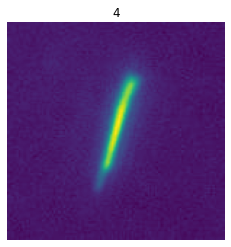

In [6]:
# Setup the train and test directories
train_dir = "NW_image_quality_50tests_noramlized/train/"
test_dir = "NW_image_quality_50tests_noramlized/test/"
# visualize
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

img = view_random_image(target_dir=train_dir,
              target_class=random.choice(class_names))

In [7]:
tf.constant(img)

<tf.Tensor: shape=(150, 150), dtype=uint8, numpy=
array([[23, 21, 18, ..., 19, 21, 21],
       [24, 22, 20, ..., 17, 21, 23],
       [24, 23, 22, ..., 19, 22, 25],
       ...,
       [19, 16, 17, ..., 17, 17, 18],
       [19, 16, 16, ..., 19, 19, 20],
       [19, 15, 14, ..., 20, 21, 21]], dtype=uint8)>

In [8]:
img = img/255.
img

array([[0.09019608, 0.08235294, 0.07058824, ..., 0.0745098 , 0.08235294,
        0.08235294],
       [0.09411765, 0.08627451, 0.07843137, ..., 0.06666667, 0.08235294,
        0.09019608],
       [0.09411765, 0.09019608, 0.08627451, ..., 0.0745098 , 0.08627451,
        0.09803922],
       ...,
       [0.0745098 , 0.0627451 , 0.06666667, ..., 0.06666667, 0.06666667,
        0.07058824],
       [0.0745098 , 0.0627451 , 0.0627451 , ..., 0.0745098 , 0.0745098 ,
        0.07843137],
       [0.0745098 , 0.05882353, 0.05490196, ..., 0.07843137, 0.08235294,
        0.08235294]])

# Preprocess the data.

In [9]:
# rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# load data in from directories and turn into batches
train_data = train_datagen.flow_from_directory(train_dir,
                        target_size=(150,150),
                        batch_size=32,
                        class_mode='categorical',
                        color_mode='grayscale',
                        shuffle=True)
test_data = test_datagen.flow_from_directory(test_dir,
                        target_size=(150,150),
                        batch_size=32,
                        class_mode='categorical',
                        color_mode='grayscale',
                        shuffle=True)

Found 2988 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.


# Data augmentation

In [10]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                      rotation_range=0.2,
                      zoom_range=0.2,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                target_size=(150,150),
                                batch_size=32,
                                class_mode="categorical",
                                color_mode='grayscale',
                                shuffle=True)

Found 2988 images belonging to 5 classes.


# Create model

In [11]:
model_1 = Sequential([
    Conv2D(10,10,activation="relu",input_shape=(150,150,1)),
    MaxPool2D(),
    Conv2D(10,10,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(5,activation="softmax")
])

In [12]:
model_1.compile(loss="categorical_crossentropy",
        optimizer=Adam(),
        metrics=["accuracy"])

In [13]:
history_1 = model_1.fit(train_data_augmented,
              epochs=50,
              steps_per_epoch=len(train_data_augmented),
              validation_data=test_data,
              validation_steps=len(test_data))

Epoch 1/50
94/94 [==============================] - 16s 77ms/step - loss: 1.5715 - accuracy: 0.2426 - val_loss: 1.5691 - val_accuracy: 0.2767
Epoch 2/50
94/94 [==============================] - 7s 75ms/step - loss: 1.4942 - accuracy: 0.3253 - val_loss: 1.3905 - val_accuracy: 0.4208
Epoch 3/50
94/94 [==============================] - 7s 74ms/step - loss: 1.4178 - accuracy: 0.3906 - val_loss: 1.4231 - val_accuracy: 0.3992
Epoch 4/50
94/94 [==============================] - 8s 88ms/step - loss: 1.3648 - accuracy: 0.4197 - val_loss: 1.3232 - val_accuracy: 0.4425
Epoch 5/50
94/94 [==============================] - 7s 74ms/step - loss: 1.3303 - accuracy: 0.4267 - val_loss: 1.2631 - val_accuracy: 0.4583
Epoch 6/50
94/94 [==============================] - 7s 74ms/step - loss: 1.3120 - accuracy: 0.4394 - val_loss: 1.2847 - val_accuracy: 0.4425
Epoch 7/50
94/94 [==============================] - 7s 74ms/step - loss: 1.2845 - accuracy: 0.4451 - val_loss: 1.2049 - val_accuracy: 0.4850
Epoch 8/50
9

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 141, 141, 10)      1010      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 70, 70, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        10010     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 10)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9000)              0         
                                                                 
 dense (Dense)               (None, 5)                 4

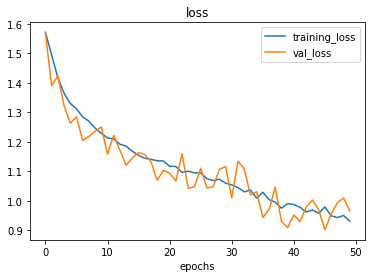

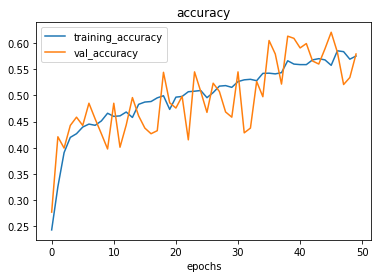

In [14]:
model_1.summary()
# plot the loss curve
plot_loss_curves(history_1)